<a href="https://colab.research.google.com/github/brenoakihiromorimoto/portf-lio/blob/main/Desafio_NVIDIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instalar e Importar Bibliotecas

In [3]:
# Bibliotecas de manipulação e visualização de gráficos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier.threshold import discrimination_threshold
from yellowbrick.classifier import ROCAUC

# Google Drive
from google.colab import drive
drive.mount('/gdrive')
# Sincronizar o Drive com o google colab
%cd /gdrive

# Pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, Normalizer, PowerTransformer
!pip install category_encoders
import category_encoders as ce

# Balanceamento de dataset
!pip install imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Modelos de machine learning e train test split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

# Métricas de classificação
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix

Mounted at /gdrive
/gdrive
     |████████████████████████████████| 86 kB 3.2 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Importar dataset de fraude

In [4]:
link = '/gdrive/MyDrive/Colab Notebooks/fraud_detection_dataset.csv'
df = pd.read_csv(link, sep=',', encoding='utf-8')
X = df.sample(frac=1)

y = X['isFraud']
X = X.drop('isFraud', axis=1)

# EDA antes do pré-processamento

In [5]:
df_EDA = df.copy()
X_EDA = X.copy()
y_EDA = y.copy()

In [6]:
var_numerica_eda = [col for col in X_EDA if X_EDA[col].dtype in ['int64', 'float64']]

In [7]:
X_EDA[var_numerica_eda] = np.log(X_EDA[var_numerica_eda]+1)

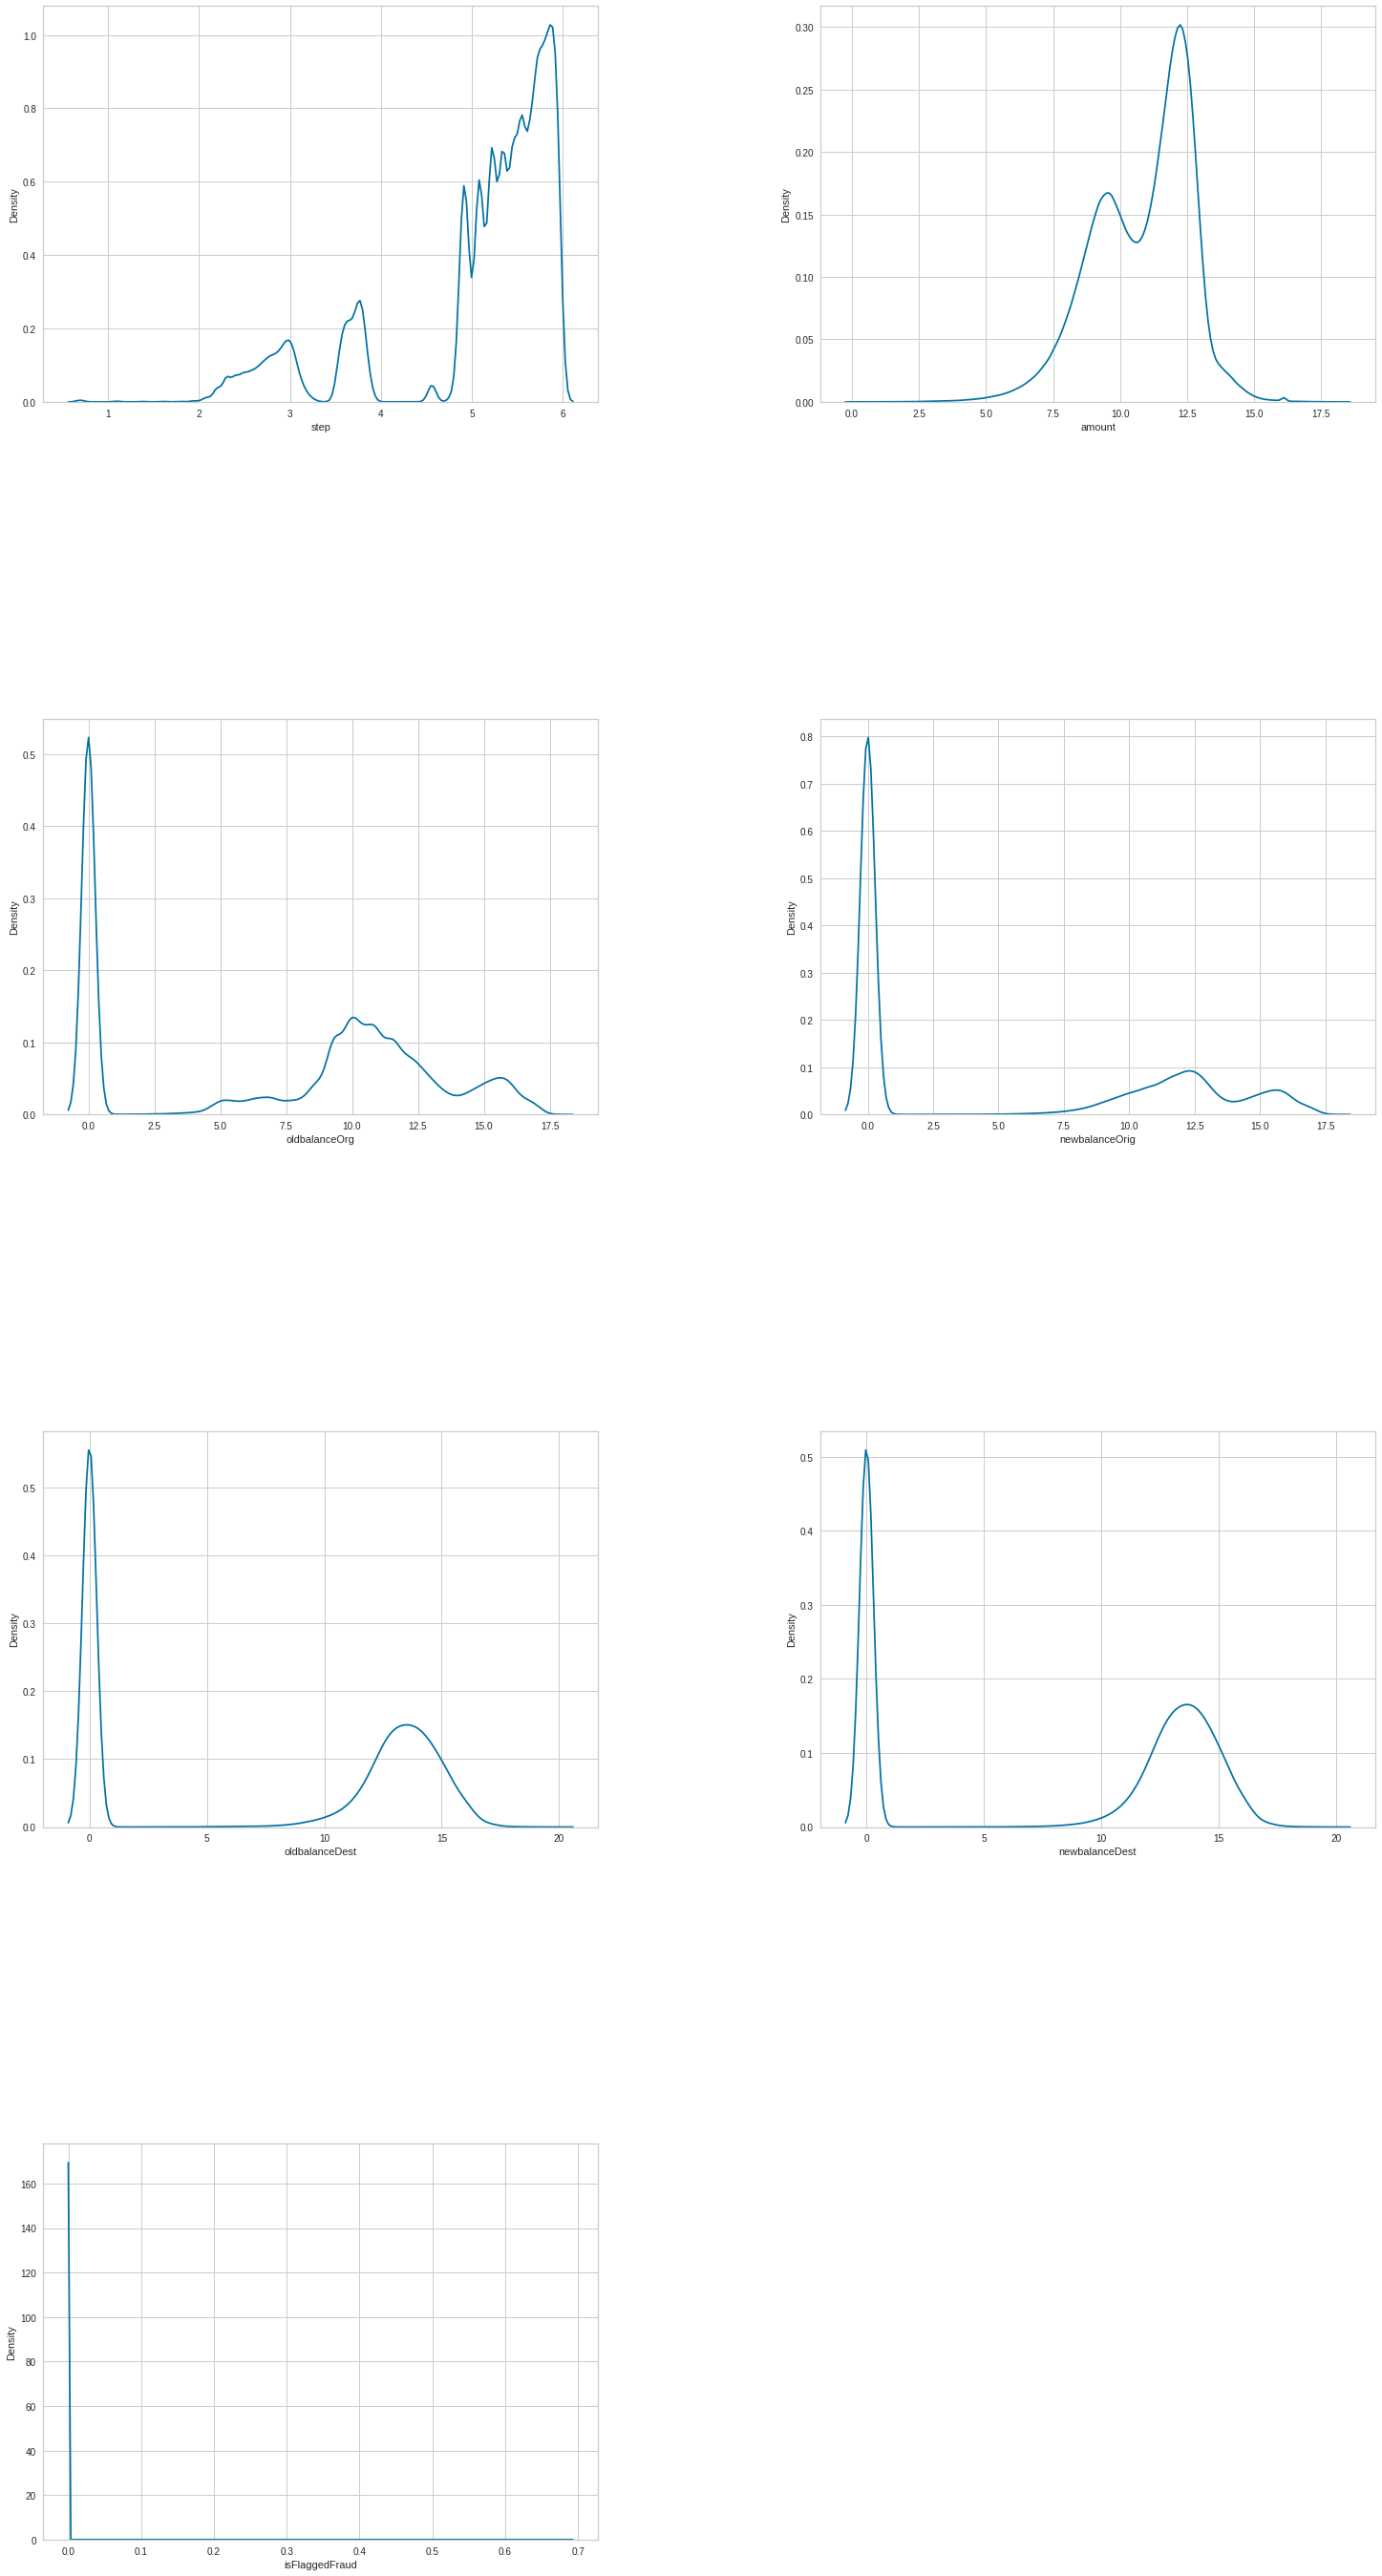

In [8]:
# Configurando a figura do matplot lib
fig = plt.figure(figsize=(25,90))
fig.subplots_adjust(hspace=0.8, wspace=0.4)
total_plots = len(var_numerica_eda)
i = 0
for var in var_numerica_eda:
  ax = fig.add_subplot(total_plots, 2, i+1)
  sns.kdeplot(data=X_EDA, x=var, ax=ax)
  i+=1

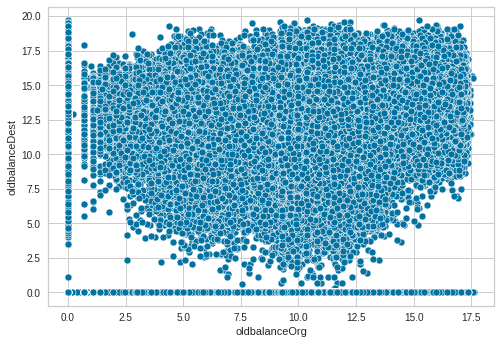

In [9]:
sns.scatterplot(data=X_EDA, x='oldbalanceOrg', y='oldbalanceDest')

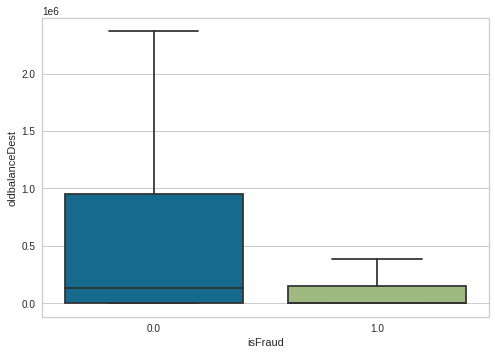

In [10]:
sns.boxplot(data=df_EDA, y='oldbalanceDest', x='isFraud', showfliers=False)

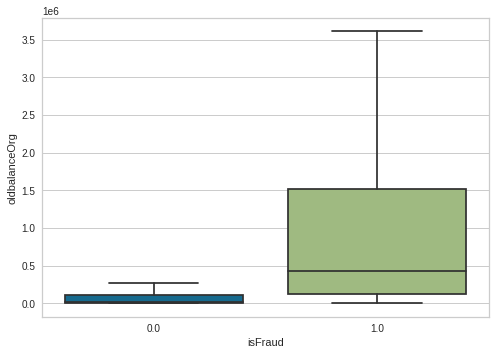

In [11]:
sns.boxplot(data=df_EDA, y='oldbalanceOrg', x='isFraud', showfliers=False)

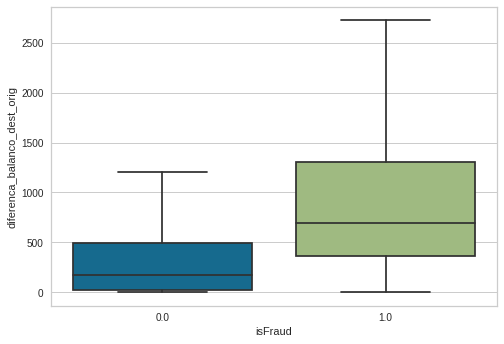

In [12]:

df_EDA['diferenca_balanco_dest_orig'] = (df_EDA['oldbalanceOrg']-(df_EDA['oldbalanceDest']))**.5

sns.boxplot(data=df_EDA, y='diferenca_balanco_dest_orig', x='isFraud', showfliers=False)

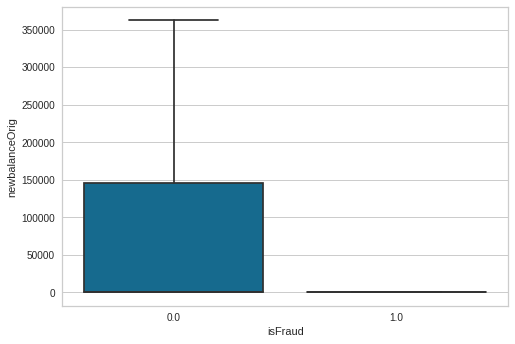

In [13]:
sns.boxplot(data=df_EDA, y='newbalanceOrig', x='isFraud', showfliers=False)

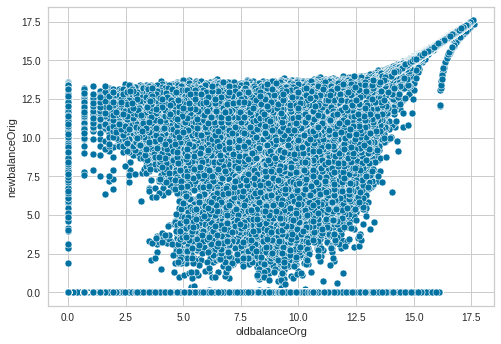

In [14]:
sns.scatterplot(data=X_EDA, x='oldbalanceOrg', y='newbalanceOrig')

* Os dois grupos, que são dos fraudadores e dos clientes, estão bem evidentes no scatterplot. 

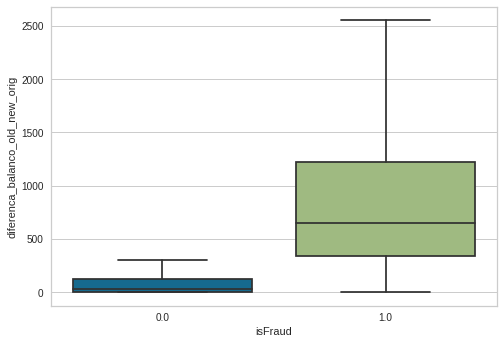

In [15]:
# Criar uma coluna de diferença
df_EDA['diferenca_balanco_old_new_orig'] = (df_EDA['oldbalanceOrg']-(df_EDA['newbalanceOrig']))**.5
sns.boxplot(data=df_EDA, y='diferenca_balanco_old_new_orig', x='isFraud', showfliers=False)


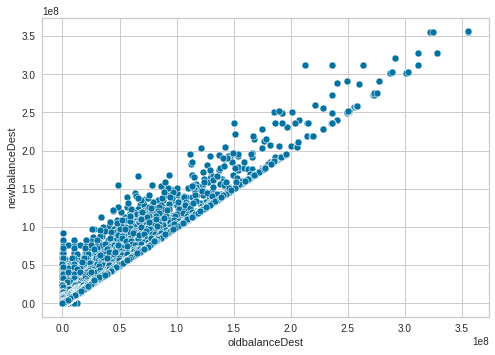

In [16]:
sns.scatterplot(data=df_EDA, x='oldbalanceDest', y='newbalanceDest')

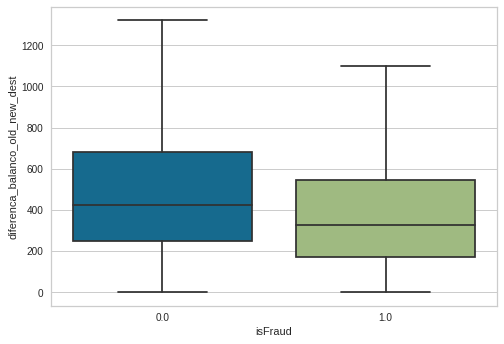

In [17]:
df_EDA['diferenca_balanco_old_new_dest'] = (df_EDA['newbalanceDest']%(df_EDA['oldbalanceDest']))**.5
sns.boxplot(data=df_EDA, y='diferenca_balanco_old_new_dest', x='isFraud', showfliers=False)

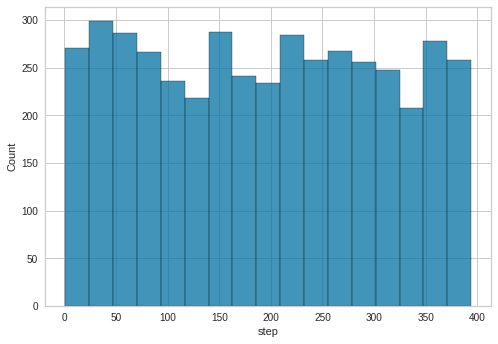

In [18]:
sns.histplot(df_EDA[df_EDA['isFraud']==1]['step'])

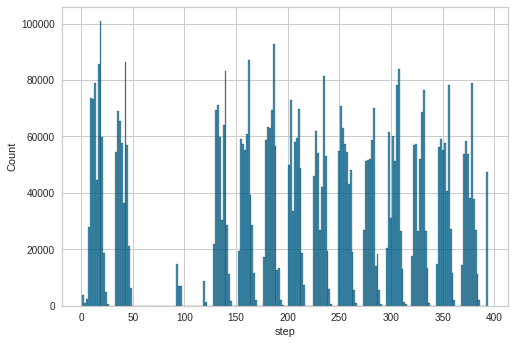

In [19]:
sns.histplot(df_EDA[df_EDA['isFraud']==0]['step'])

In [20]:
df_EDA[df_EDA['isFraud']==0][['step']].value_counts().sort_index().iloc[220:250]

step
346     26067
347     30222
348     29459
349     29534
350     28231
351     26909
352     27123
353     30412
354     40684
355     44779
356     33522
357     15078
358     12040
359      7979
360      3500
361      1427
362       484
369     14484
370     25411
371     28382
372     29507
373     28841
374     27713
375     26093
376     20118
377     18173
378     37123
379     41743
380     37679
381     14957
dtype: int64

In [21]:
df_EDA[df_EDA['isFraud']==1][['step']].value_counts().sort_index().iloc[90:110]

step
91       8
92      10
93      16
94      12
95      14
96       4
97      10
98      14
99       8
100      6
101     12
102     12
103      8
104     14
105     18
106     18
107     10
108      8
109     12
110     10
dtype: int64

* Posso agrupar nos períodos com poucos clientes:
- Períodos:
  * 28-32
  * 42-92
  * 98-118
  * 124-128
  * 148-152
  * 171-176
  * 196-200
  * 218-224
  * 243-248
  * 268-272
  * 292-296
  * 315-320
  * 339-344
  * 363-368

In [24]:
#vamos criar os limites das faixas etárias para os nossos dados  
step_cat_edges = [0, 
                  28, 32, 
                  42, 92, 
                  98, 118, 
                  124, 128, 
                  148, 152, 
                  171, 176, 
                  196, 200, 
                  218, 224, 
                  243, 248, 
                  268, 272, 
                  292, 296, 
                  315, 320,
                  339, 344,
                  363, 368,
                  1000]
labels = [0, 
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0]

#crie uma nova coluna :: selecione a coluna base
df_EDA['step_cat'] = pd.cut(df_EDA['step'],                             
                             #aplique os limites de cada categoria
                             step_cat_edges, 
                             #nomei cada categoria
                             labels=labels, ordered=False)

In [32]:
df_EDA['step_cat'].value_counts()/df_EDA['step_cat'].value_counts().sum()

0    0.976659
1    0.023341
Name: step_cat, dtype: float64

In [33]:
df_EDA[df_EDA['isFraud']==0][(df_EDA['step']>50)][(df_EDA['step']<90)]['step']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Series([], Name: step, dtype: int64)

In [34]:
df_EDA[df_EDA['isFraud']==1][(df_EDA['step']>50)][(df_EDA['step']<90)]['step']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


1030263    51
1030264    51
1030265    51
1030266    51
1030267    51
           ..
1030740    89
1030741    89
1030742    89
1030743    89
1030744    89
Name: step, Length: 482, dtype: int64

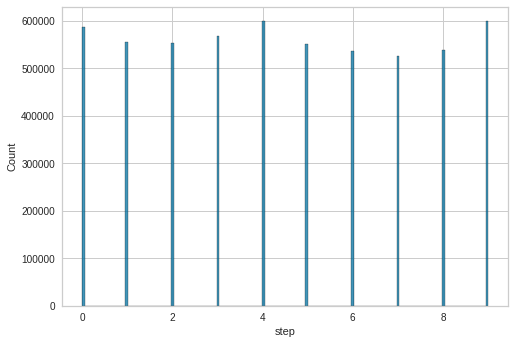

In [35]:
sns.histplot(df_EDA['step']%10)

# Pré-Processamento

In [510]:
X_preprocessed = df.drop(['isFraud'], axis=1).copy()
y_preprocessed = df['isFraud']
X_preprocessed['type'] = X_preprocessed['type'].astype('string')
X_preprocessed['type'] = X_preprocessed['type'].map({'PAYMENT': 0,
                                                    'TRANSFER': 1,
                                                    'CASH_OUT': 2,
                                                    'CASH_IN': 3}, na_action='ignore')


In [511]:
#vamos criar os limites das faixas etárias para os nossos dados  
step_cat_edges = [0, 
                  28, 32, 
                  42, 92, 
                  98, 118, 
                  124, 128, 
                  148, 152, 
                  171, 176, 
                  196, 200, 
                  218, 224, 
                  243, 248, 
                  268, 272, 
                  292, 296, 
                  315, 320,
                  339, 344,
                  363, 368,
                  1000]
labels = [0, 
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0,
          1,
          0]

#crie uma nova coluna :: selecione a coluna base
X_preprocessed['step_cat'] = pd.cut(X_preprocessed['step'],                             
                             #aplique os limites de cada categoria
                             step_cat_edges, 
                             #nomei cada categoria
                             labels=labels, ordered=False)

Criando novas features

In [512]:
# tentativas de criar features
#X_preprocessed['nameDest_letra_0'] = X_preprocessed['nameDest'].astype(str).str[0].map({'C': 0, 'M': 1, 'n':3}, na_action='ignore')

In [513]:
X_preprocessed.info(verbose=True, null_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611398 entries, 0 to 5611397
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype   
---  ------          --------------    -----   
 0   step            5611398 non-null  int64   
 1   type            5575381 non-null  float64 
 2   amount          5611398 non-null  float64 
 3   nameOrig        5611397 non-null  object  
 4   oldbalanceOrg   5611397 non-null  float64 
 5   newbalanceOrig  5611397 non-null  float64 
 6   nameDest        5611397 non-null  object  
 7   oldbalanceDest  5611397 non-null  float64 
 8   newbalanceDest  5611397 non-null  float64 
 9   isFlaggedFraud  5611397 non-null  float64 
 10  step_cat        5611398 non-null  category
dtypes: category(1), float64(7), int64(1), object(2)
memory usage: 433.5+ MB


In [514]:
X_preprocessed

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,step_cat
0,1,0.0,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.00,0.00,0.0,0
1,1,0.0,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.00,0.00,0.0,0
2,1,1.0,181.00,C1305486145,181.0,0.00,C553264065,0.00,0.00,0.0,0
3,1,2.0,181.00,C840083671,181.0,0.00,C38997010,21182.00,0.00,0.0,0
4,1,0.0,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.00,0.00,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
5611393,394,3.0,43774.10,C1390942705,11919.0,55693.10,C479375067,291762.28,247988.18,0.0,0
5611394,394,2.0,238865.40,C210651735,24890.0,0.00,C1434161357,1138240.76,1377106.15,0.0,0
5611395,394,3.0,291213.86,C96301416,995.0,292208.86,C1089379775,4839172.58,4547958.72,0.0,0
5611396,394,1.0,254957.98,C399832294,11559.0,0.00,C319236493,0.00,254957.98,0.0,0


In [515]:
# Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y_preprocessed, random_state=0)

In [516]:
var_numerica = [col for col in X_preprocessed if X_preprocessed[col].dtype in ['float64', 'int64']]
var_categorica = [col for col in X_preprocessed if X_preprocessed[col].dtype in ['object', 'category']]

In [517]:
# Função de Pré-processamento: limpeza, transformação e balanceamento de dataset
def random_forest_classifier_preprocessing(X_train, y_train, X_val, y_val):
  # Imputar variáveis numéricas faltantes
  si_median = SimpleImputer(strategy='median')
  X_train[var_numerica] = si_median.fit_transform(X_train[var_numerica])
  X_val[var_numerica] = si_median.fit_transform(X_val[var_numerica])
  y_train = si_median.fit_transform(y_train.array.reshape(-1, 1)) 
  y_val = si_median.fit_transform(y_val.array.reshape(-1, 1)) 
 
  # Imputar variáveis categóricas faltantes
  si_frequent = SimpleImputer(strategy='most_frequent')
  X_train[var_categorica] = si_frequent.fit_transform(X_train[var_categorica])
  X_val[var_categorica] = si_frequent.fit_transform(X_val[var_categorica])

  # Transformar variáveis categóricas por HashEncoder
  # Alta escalabilidade já que a base de clientes pode aumentar
  X_train['nameOrig'] = pd.util.hash_pandas_object(X_train['nameOrig'])%10
  X_train['nameDest'] = pd.util.hash_pandas_object(X_train['nameDest'])%10
  X_val['nameOrig'] = pd.util.hash_pandas_object(X_val['nameOrig'])%10
  X_val['nameDest'] = pd.util.hash_pandas_object(X_val['nameDest'])%10
  return X_train, y_train, X_val, y_val
def undersampler(X_train, y_train):
  # Balancear dataset X_train e y_train
  XR, yR = RandomUnderSampler(random_state=0, sampling_strategy=0.01).fit_resample(X_train, y_train)
  X_rsamp = pd.DataFrame(columns=X_train.columns, data=XR)
  y_rsamp = pd.DataFrame(data=yR)

  return X_rsamp, y_rsamp

In [518]:
# Pré-processamento
X_train, y_train, X_val, y_val = random_forest_classifier_preprocessing(X_train, y_train, X_val, y_val)
X_rsamp, y_rsamp = undersampler(X_train, y_train)

In [519]:
X_train['type'].value_counts()

2.0    1513791
0.0    1420976
3.0     923903
1.0     349878
Name: type, dtype: int64

In [520]:
X_val.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1402850 entries, 4049088 to 1946893
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1402850 non-null  float64
 1   type            1402850 non-null  float64
 2   amount          1402850 non-null  float64
 3   nameOrig        1402850 non-null  uint64 
 4   oldbalanceOrg   1402850 non-null  float64
 5   newbalanceOrig  1402850 non-null  float64
 6   nameDest        1402850 non-null  uint64 
 7   oldbalanceDest  1402850 non-null  float64
 8   newbalanceDest  1402850 non-null  float64
 9   isFlaggedFraud  1402850 non-null  float64
 10  step_cat        1402850 non-null  object 
dtypes: float64(8), object(1), uint64(2)
memory usage: 128.4+ MB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


#EDA pós pré-processamento

In [196]:
# Dataframe para fazer EDA
df_preprocessed = pd.concat([X_train, pd.Series(y_train.ravel())], axis=1)
df_preprocessed.rename(columns={0:'isFraud'}, inplace=True)

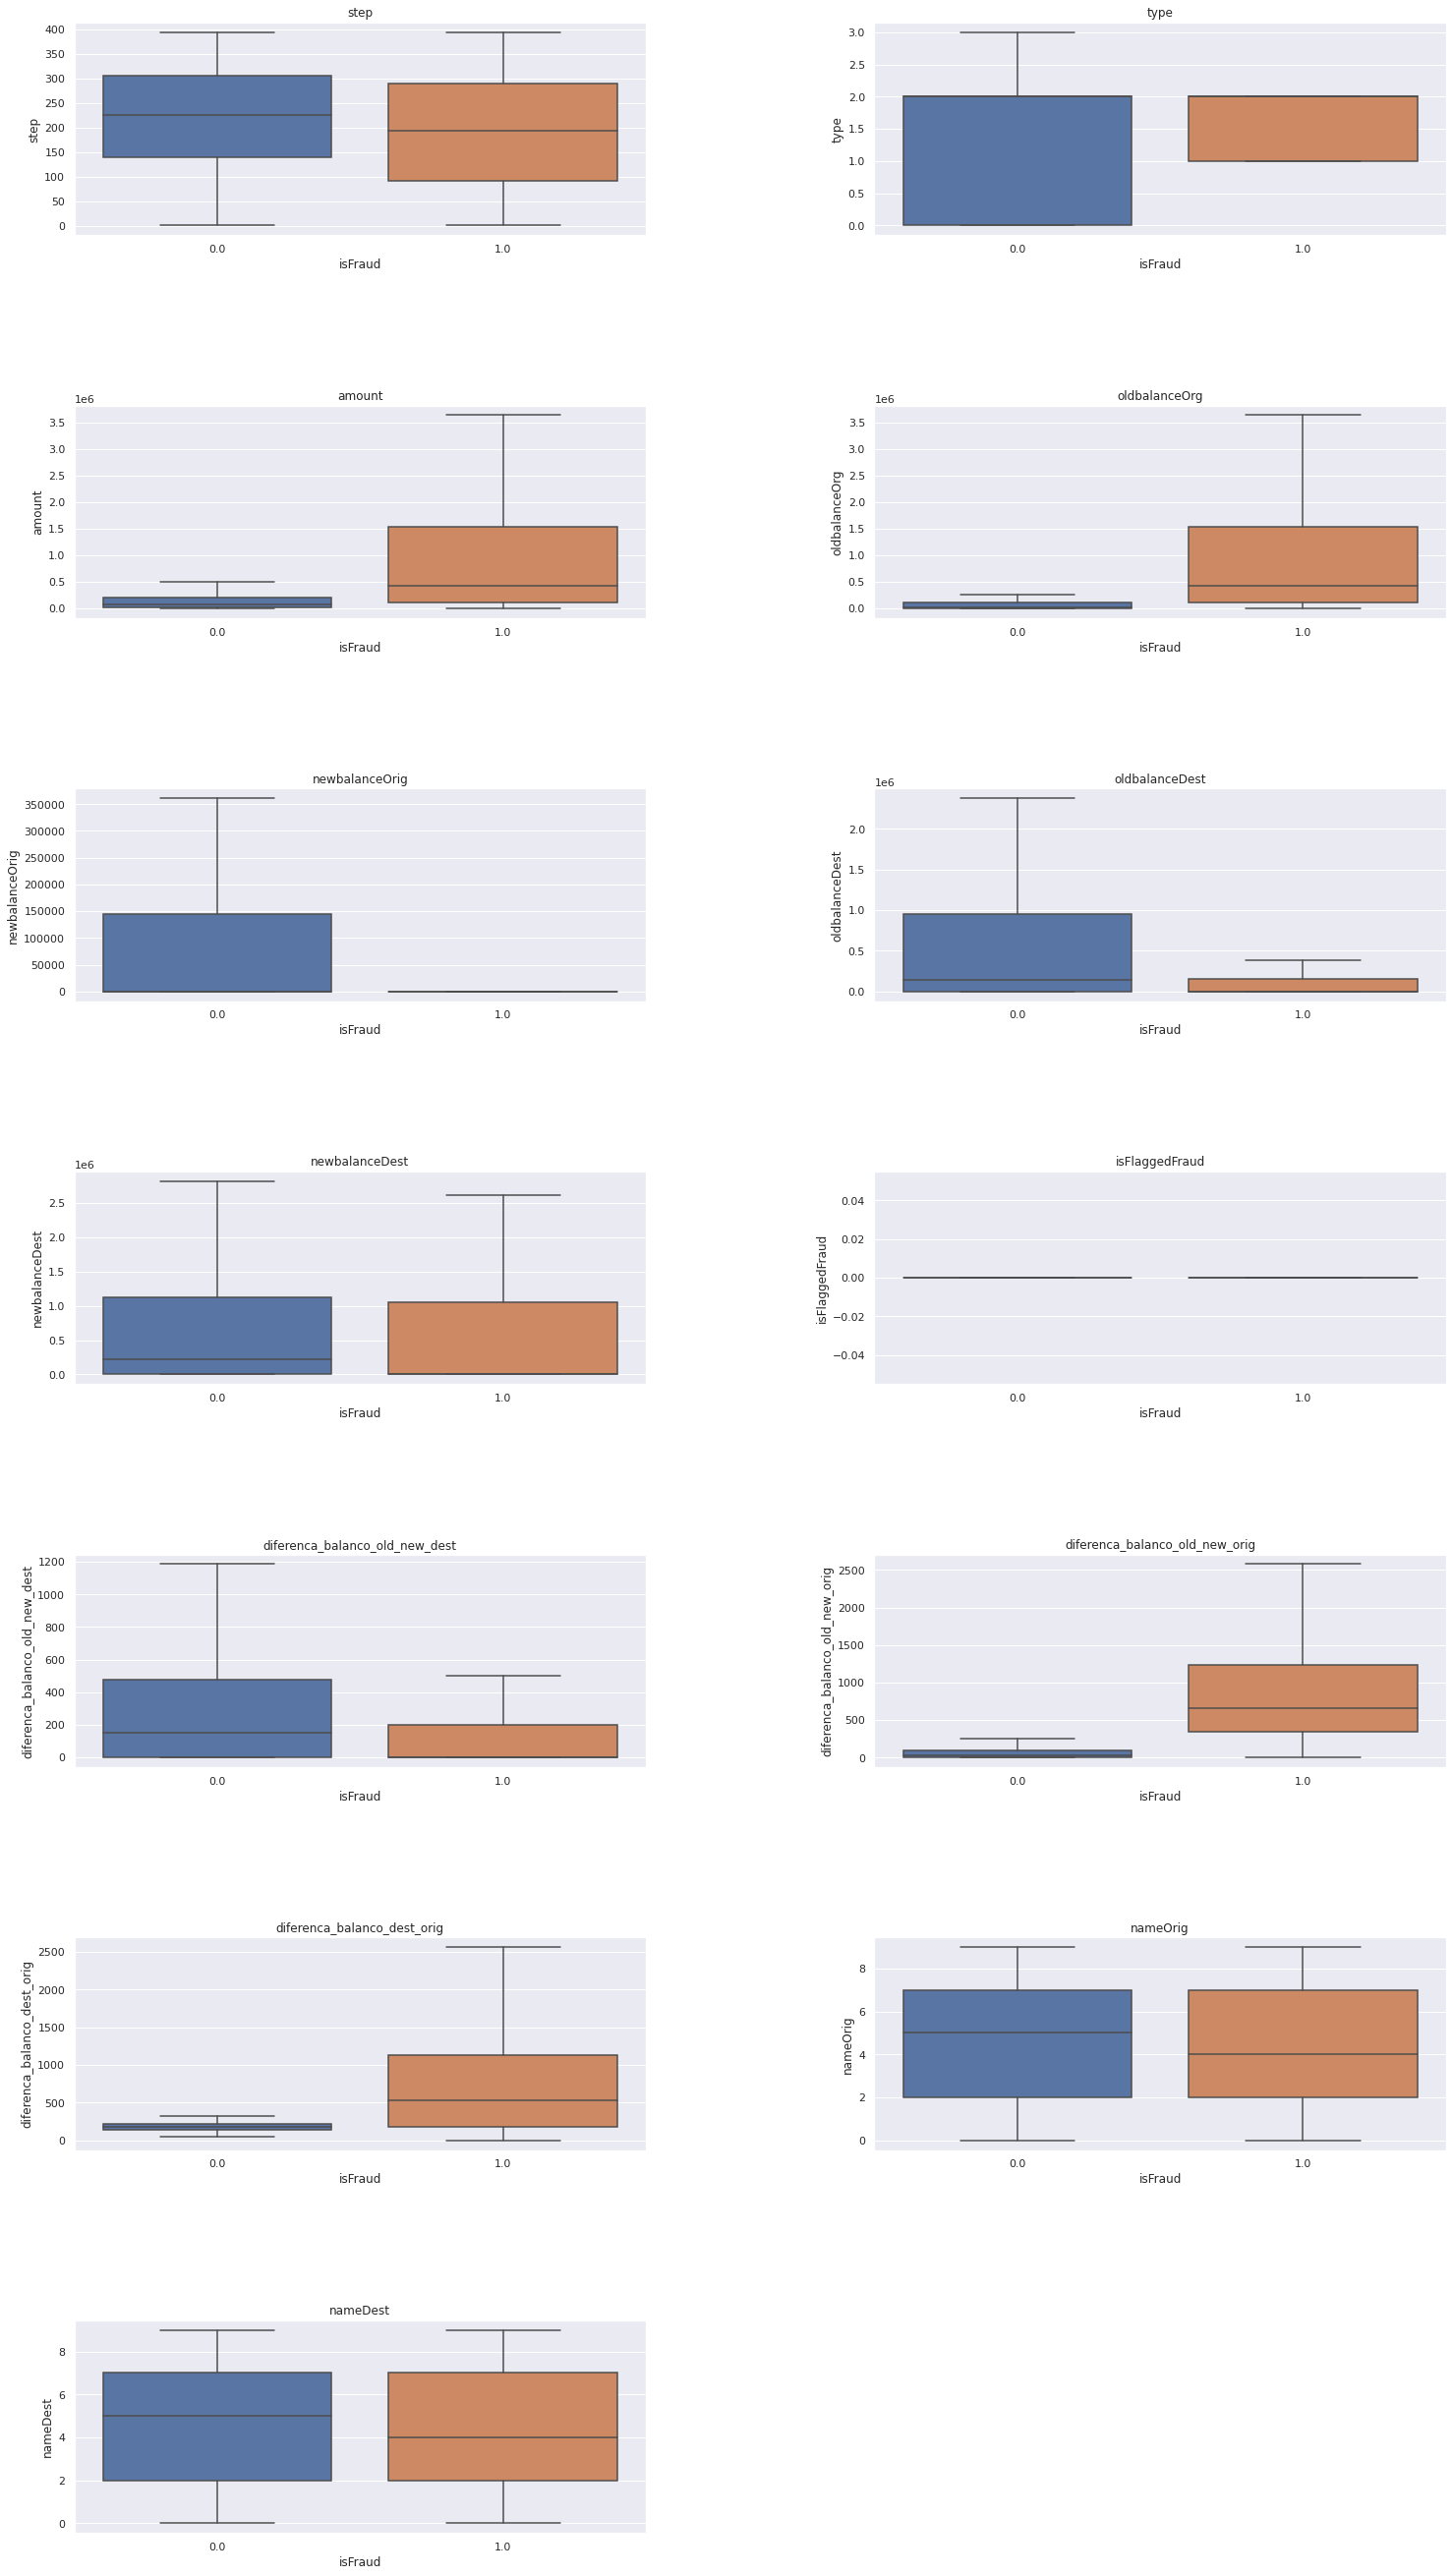

In [ ]:
# Configurando o matplotlib
fig = plt.figure(figsize=(25, 90))
fig.subplots_adjust(hspace=0.8, wspace=0.4)
total_plot = len(var_numerica+var_categorica)
i = 0
# Iterar variáveis categóricas
for var in var_numerica+var_categorica:
  ax = fig.add_subplot(total_plot, 2, i+1)
  sns.boxplot(data=df_preprocessed, x='isFraud', y=var, showfliers=False)
  ax.set_title(var)
  i += 1

Variáveis relacionadas à fraude.
* Amount  
* OldBalanceOrg
* NewBalanceDest
* NameDest
* Type 
  * 1 e 2 estão associados à fraude. TRANSFER E CASHOUT.



In [ ]:
df_preprocessed[['isFraud', 'type']].groupby('isFraud').agg(['value_counts'])

type
             value_counts
isFraud type             
0.0     2.0         11751
        0.0         10963
        3.0          7282
        1.0          2784
1.0     2.0          1647
        1.0          1631

In [ ]:
df_preprocessed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4208548 entries, 2895896 to 545713
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            float64
 1   type            float64
 2   amount          float64
 3   nameOrig        uint64 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        uint64 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFlaggedFraud  float64
 10  isFraud         float64
dtypes: float64(9), uint64(2)
memory usage: 514.3 MB


In [ ]:
df_preprocessed.describe().round(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
count,4208548.00,4208548.00,4208548.00,4208548.00,4208548.00,4208548.00,4208548.00,4.208548e+06,4.208548e+06,4208548.0,4208547.00
mean,211.12,1.46,181043.87,4.50,843159.27,864995.00,4.50,1.086898e+06,1.215102e+06,0.0,0.00
std,112.92,1.17,627609.11,2.87,2923030.06,2959829.81,2.87,3.279673e+06,3.590505e+06,0.0,0.03
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.0,0.00
25%,139.00,0.00,13320.40,2.00,0.00,0.00,2.00,0.000000e+00,0.000000e+00,0.0,0.00
50%,225.00,2.00,75161.91,4.00,13914.64,0.00,4.00,1.354523e+05,2.178226e+05,0.0,0.00
75%,305.00,2.00,209154.44,7.00,107331.00,144649.70,7.00,9.470660e+05,1.118933e+06,0.0,0.00
max,394.00,3.00,92445516.64,9.00,44892193.09,43686616.33,9.00,3.551855e+08,3.555534e+08,1.0,1.00


## Contas de origem e destino

df_EDA_contas

In [ ]:
df_EDA_contas = df_EDA.copy()
# df_EDA_contas['nameOrig'] = pd.util.hash_pandas_object(df_EDA['nameOrig'])%10
df_EDA_contas['nameOrig'] = (df_EDA['nameOrig'].astype(str).str[2])

In [ ]:
df_EDA_contas[['isFraud', 'nameOrig']].groupby('isFraud').agg(['value_counts'])

In [ ]:
df_EDA_contas['nameOrig'] = df_EDA_contas['nameOrig']
sns.histplot(data=df_EDA_contas[df_EDA_contas['isFraud']==0], x='nameOrig', stat='probability')

In [ ]:
sns.histplot(data=df_EDA_contas[df_EDA_contas['isFraud']==1], x='nameOrig', stat='probability')

In [ ]:
df_EDA_contas[df_EDA_contas['isFraud']==0]['nameOrig'].std()

In [ ]:
df_EDA_contas[df_EDA_contas['isFraud']==1]['nameOrig'].std()

In [ ]:
df_EDA_contas['nameOrig'] = (df_EDA['nameOrig'].astype(str).str[3]).astype(float)

In [ ]:
print(df_EDA_contas[df_EDA_contas['isFraud']==0]['nameOrig'].std()-df_EDA_contas[df_EDA_contas['isFraud']==1]['nameOrig'].std())

A diferença do desvio-padrão de cada número no código do cliente: 
* str[8]: -0.024
* str[7]: -0.004
* str[6]: 0.023
* str[5]: 0.02
* str[4]: 0.011
* str[3]: -0.01

* É perceptível um maior desvio-padrão para casos de não fraude nas str[6, 5, 4] do que em casos de fraude.
* É perceptível um menor desvio-padrão para casos de não fraude nas str[8, 7, 3] do que em casos de fraude.



In [ ]:
df_EDA_contas['nameOrig_str'] = (df_EDA['nameOrig'].astype(str).str[4, 5, 6]).astype(float)
df_EDA_contas['nameOrig_str'] = df_EDA['nameOrig_str']

In [ ]:
sns.boxplot(data=df_EDA_contas, x='isFraud', y='nameOrig_str')

* Não mudou nada

In [ ]:
df_EDA_contas['nameDest_str'] = df_EDA_contas['nameDest'].astype(str).str[0].map({'C': 0, 'M': 1, 'n':3})

In [ ]:
df_EDA_contas[['nameDest_str', 'isFraud']].groupby('isFraud').agg(['value_counts'])

* É visível que a primeira letra define se a conta é de um fraudador ou não. Todas as contas consideradas fraude começam com a letra C

# Treino e validação do modelo

In [483]:
# Função de resultados
def resultado(modelo, y_val, previsao): 
    data = {'Modelo': [modelo],
            'Accuracy': [accuracy_score(y_val, previsao).round(2)],
            'Precision': [precision_score(y_val, previsao).round(2)],
            'Recall': [recall_score(y_val, previsao).round(2)],
            'F1-Score': [f1_score(y_val, previsao).round(2)]}
    resultados = pd.DataFrame(data)
    # Matriz de confusão
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.heatmap(confusion_matrix(y_val, previsao), annot=True)
    return resultados

## Random Forest

### Treino do modelo

In [521]:
# treino do random forest
random_forest = RandomForestClassifier(random_state=0, 
                                       n_estimators=150, class_weight='balanced')
# Treinar modelo
random_forest.fit(X_rsamp, y_rsamp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(class_weight='balanced', n_estimators=150,
                       random_state=0)

In [522]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,step_cat
5202053,369.0,2.0,591050.51,5,305354.00,0.00,7,3163323.47,3754373.98,0.0,0
4467478,324.0,0.0,11733.53,9,0.00,0.00,9,0.00,0.00,0.0,0
4537632,326.0,0.0,11596.64,7,282.00,0.00,2,0.00,0.00,0.0,0
3197829,249.0,0.0,24907.07,7,0.00,0.00,5,0.00,0.00,0.0,0
990077,45.0,0.0,17991.78,9,57620.25,39628.47,5,0.00,0.00,0.0,1


### Validação do modelo

,Modelo,Accuracy,Precision,Recall,F1-Score
0,Undersampling,1.0,0.96,0.81,0.87


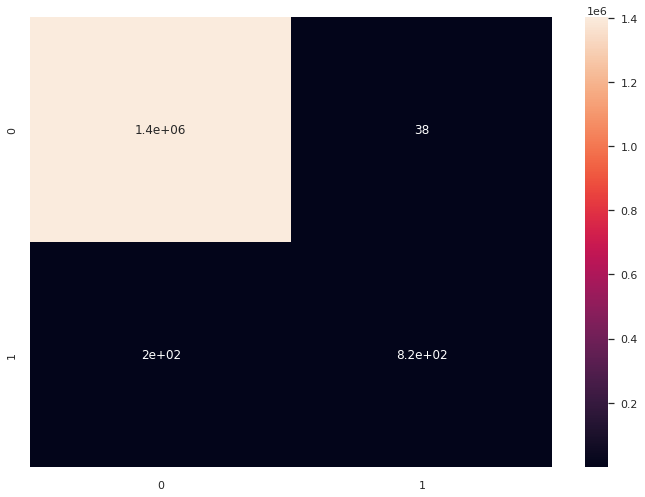

In [523]:
# validar random_forest
previsao_prob = random_forest.predict_proba(X_val)
threshold = 0.6
previsao = (previsao_prob[:, 1]>=threshold).astype(bool)
# Resultados
resultado('Undersampling', y_val, previsao)

### Analisar Threshold, ROC e AUC

In [524]:
y_val

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [525]:
y_val.ravel()

array([0., 0., 0., ..., 0., 0., 0.])

* Descobrir o threshold 

In [526]:
def calculate_far_frr(y_proba, y_true, n_points=30, normalize=False, threshold=None):
    thr = np.linspace(0, 1, n_points)
    far = []
    frr = []
    for t in thr:
        far_pt = y_proba[y_true == 0] >= t
        frr_pt = y_proba[y_true == 1] <= t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())
    if threshold is None:
        far = np.array(far)
        frr = np.array(frr)
        optm = thr[abs(far - frr).argmin()]
    else:
        optm = threshold
    return {
        'optm': optm,
        'plot': pd.DataFrame(
            index=thr,
            data={
                'far': far,
                'frr': frr,
            },
            dtype=float
        )
    }

In [527]:
y_pred_test = previsao_prob[:, 1]
output_test = pd.DataFrame(
    index=[f'transação_{n+1:03d}' for n in range(y_pred_test.shape[0])],
    data={
        'probabilidade': y_pred_test,
        'decisão': (y_pred_test > 0.9).astype(int),
        'target': y_val.ravel(),
    }
)

In [528]:
output_test.sort_values(by='probabilidade')

,probabilidade,decisão,target
transação_001,0.0,0,0.0
transação_926329,0.0,0,0.0
transação_926328,0.0,0,0.0
transação_926327,0.0,0,0.0
transação_926326,0.0,0,0.0
...,...,...,...
transação_146019,1.0,1,1.0
transação_1087545,1.0,1,1.0
transação_970606,1.0,1,1.0
transação_406474,1.0,1,1.0


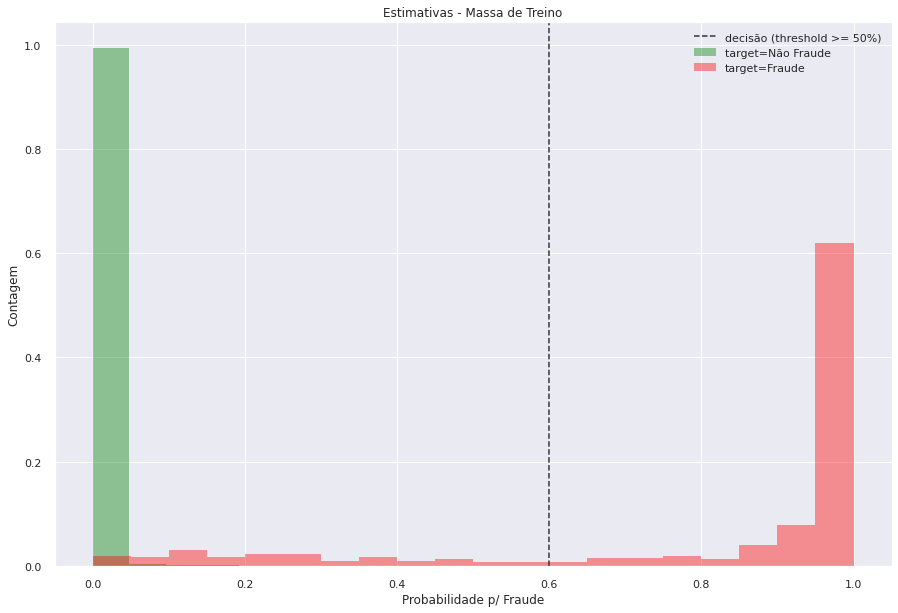

In [529]:
bins=20
alpha=0.4
linewidth=0

plt.figure(figsize=(15, 10))
sns.histplot(
    output_test.loc[output_test['target'] == 0, 'probabilidade'],
    bins=bins, color='green', alpha=alpha, linewidth=linewidth, label='target=Não Fraude', stat='probability'
)
sns.histplot(
    output_test.loc[output_test['target'] == 1, 'probabilidade'], 
    bins=bins, color='red', alpha=alpha, linewidth=linewidth, label='target=Fraude', stat='probability'
)
plt.axvline(0.6, ls='--', color='#333333', label='decisão (threshold >= 50%)')
plt.xlabel('Probabilidade p/ Fraude', fontdict={'size': 12})
plt.ylabel('Contagem', fontdict={'size': 12})
plt.title('Estimativas - Massa de Treino', fontdict={'size': 12})
plt.grid(True)
plt.legend();

In [530]:
def calculate_far_frr(y_proba, y_true, n_points=30, normalize=False, threshold=None):
    thr = np.linspace(0, 1, n_points)
    far = []
    frr = []
    for t in thr:
        far_pt = y_proba[y_true == 0] >= t
        frr_pt = y_proba[y_true == 1] <= t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())
    if threshold is None:
        far = np.array(far)
        frr = np.array(frr)
        optm = thr[abs(far - frr).argmin()]
    else:
        optm = threshold
    return {
        'optm': optm,
        'plot': pd.DataFrame(
            index=thr,
            data={
                'far': far,
                'frr': frr,
            },
            dtype=float
        )
    }

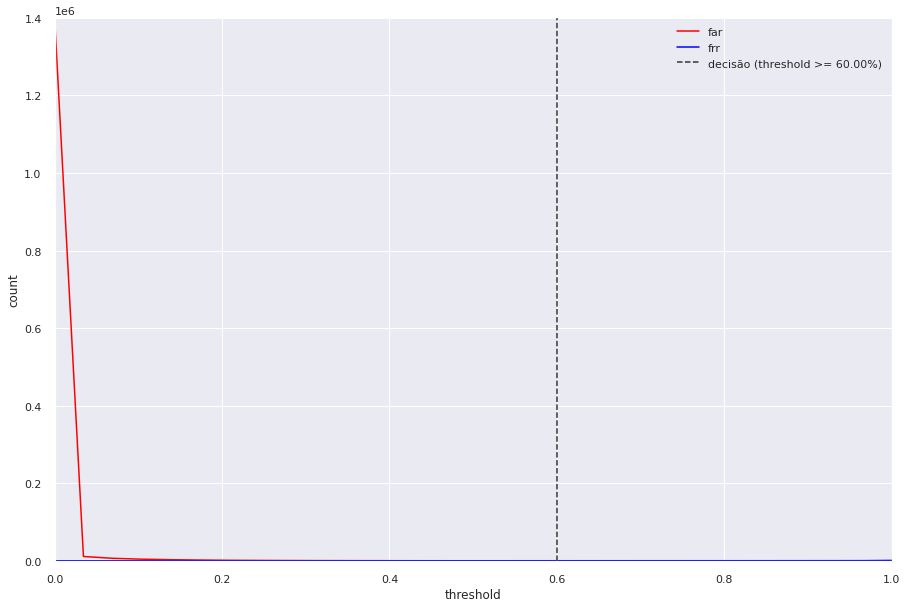

In [531]:
ffdf = calculate_far_frr(output_test['probabilidade'], output_test['target'], n_points=30, normalize=False, threshold=0.6)
plt.figure(figsize=(15,10))
ffdf['plot']['far'].plot(ax=plt.gca(), c='red')
ffdf['plot']['frr'].plot(ax=plt.gca(), c='blue')
plt.axvline(ffdf['optm'], ls='--', color='#333333', label=f'decisão (threshold >= {ffdf["optm"] * 100:5.2f}%)')
plt.grid(True)
plt.xlim(0, 1)
plt.ylim(0, ffdf['plot'].max().max())
plt.xlabel('threshold')
plt.ylabel('count')
plt.legend();

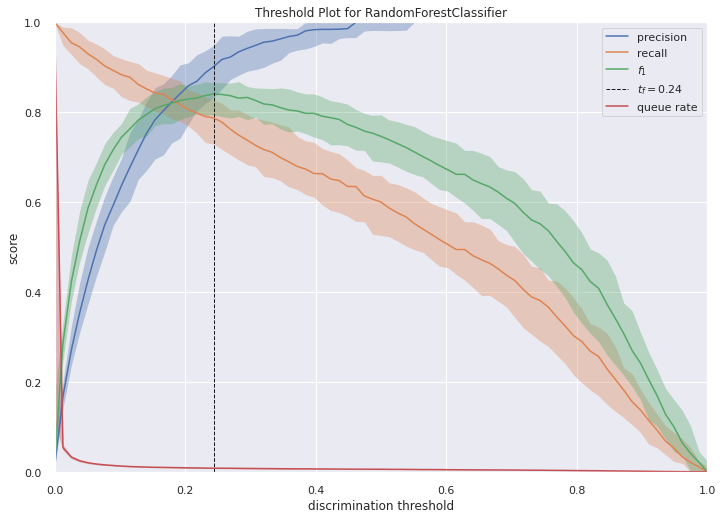

In [532]:
df_viz = X_rsamp
df_viz['isFraud'] = y_rsamp
df_viz = df_viz.sample(n=20000, random_state=0)
df_viz = df_viz
X_viz = df_viz.drop('isFraud', axis=1)
y_viz = df_viz['isFraud']
viz = discrimination_threshold(random_forest, X_viz, y_viz, cv=0.5, random_state=0, is_fitted=False)


In [533]:
df_viz

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,step_cat,isFraud
246321,39.0,3.0,376901.00,9,22536.00,399437.0,0,2443512.30,2467399.82,0.0,0,0.0
57451,41.0,0.0,9875.85,6,0.00,0.0,6,0.00,0.00,0.0,0,0.0
206307,231.0,2.0,359776.45,9,5432.00,0.0,9,6486157.05,6845933.50,0.0,0,0.0
235867,233.0,2.0,283593.13,8,13022.42,0.0,2,392560.34,321294.30,0.0,0,0.0
42111,306.0,1.0,1042274.62,8,0.00,0.0,5,2131387.38,3173662.00,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
191790,236.0,0.0,75699.41,0,0.00,0.0,3,0.00,0.00,0.0,0,0.0
256390,279.0,0.0,18678.61,7,8459.00,0.0,1,0.00,0.00,0.0,0,0.0
213602,183.0,0.0,9834.30,0,0.00,0.0,6,0.00,0.00,0.0,0,0.0
260999,255.0,1.0,505604.45,6,0.00,0.0,1,10568133.54,11073737.99,0.0,0,0.0


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


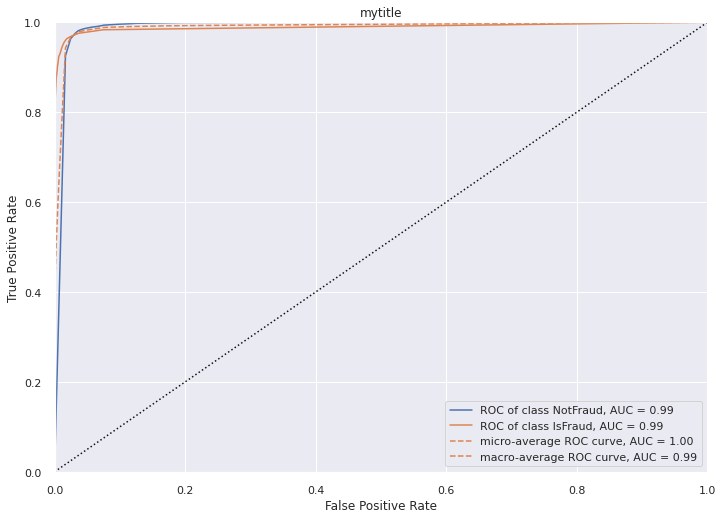

In [534]:
roc_auc_viz = ROCAUC(random_forest, classes=['NotFraud', 'IsFraud'], title='mytitle')
roc_auc_viz.fit(X_train, y_train)
roc_auc_viz.score(X_val, y_val)
roc_auc_viz.show()

### Resultados do Modelo RandomForestClassifier

In [535]:
if 'tabela_resultado_geral' not in globals().keys():
  tabela_resultado_geral = pd.DataFrame(data={'Modelo': [],
                                        'Accuracy': [],
                                        'Precision': [],
                                        'Recall': [],
                                        'F1-Score': []})

In [536]:
def adicionar_resultado(tabela_resultado_geral, adicionar='não'):
  if adicionar!='não':
    tabela_resultado_geral = tabela_resultado_geral.append(resultado('Undersampling_custom', y_val, previsao)).copy()
  return tabela_resultado_geral

In [537]:
tabela_resultado_geral = adicionar_resultado(tabela_resultado_geral, adicionar='não')
tabela_resultado_geral

,Modelo,Accuracy,Precision,Recall,F1-Score


* Baseline (n_estimators=150, random_state=0) 
  * Accuracy: 1.0	
  * Precision: 0.00	
  * Recall: 0.00	
  * F1-Score: 0.00

* Undersampling_custom (n_estimators=150, random_state=0, sampling_strategy=0.01):
  * Accuracy: 1.0
  * Precision: 0.79
  * Recall: 0.82	
  * F1-Score: 0.81

* Undersampling_custom + class_weight (n_estimators=150, random_state=0, sampling_strategy=0.01, class_weight='balanced'):
  * Accuracy: 1.0
  * Precision: 0.83
  * Recall: 0.81	
  * F1-Score: 0.82

* Undersampling_custom + class_weight + coluna step_cat(n_estimators=150, random_state=0, sampling_strategy=0.01, class_weight='balanced'):
  * Accuracy: 1.0
  * Precision: 0.88
  * Recall: 0.82	
  * F1-Score: 0.85

* Undersampling_custom + class_weight + coluna step_cat(n_estimators=150, random_state=0, sampling_strategy=0.01, class_weight='balanced', threshold=0.6):
  * Accuracy: 1.0
  * Precision: 0.96
  * Recall: 0.81
  * F1-Score: 0.87


## Importância das features

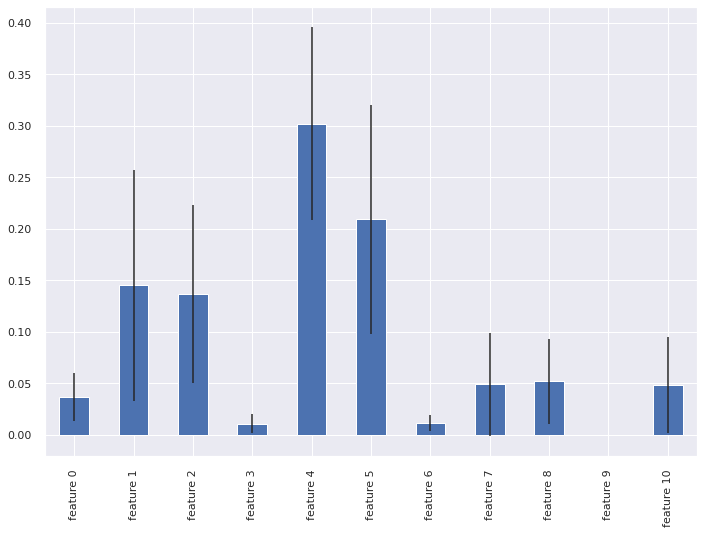

In [501]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.plot.bar(yerr=std, ax=ax)

In [502]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,step_cat
5202053,369.0,2.0,591050.51,5,305354.00,0.00,7,3163323.47,3754373.98,0.0,0
4467478,324.0,0.0,11733.53,9,0.00,0.00,9,0.00,0.00,0.0,0
4537632,326.0,0.0,11596.64,7,282.00,0.00,2,0.00,0.00,0.0,0
3197829,249.0,0.0,24907.07,7,0.00,0.00,5,0.00,0.00,0.0,0
990077,45.0,0.0,17991.78,9,57620.25,39628.47,5,0.00,0.00,0.0,1


In [503]:
# transformar alguns dados categóricos 
X_preprocessed = df.drop(['isFraud'], axis=1).copy()
y_preprocessed = df['isFraud']
X_preprocessed['type'] = X_preprocessed['type'].astype('string')

X_preprocessed['type'] = X_preprocessed['type'].map({'PAYMENT': 0,
                                                    'TRANSFER': 1,
                                                    'CASH_OUT': 2,
                                                    'CASH_IN': 3}, na_action='ignore')

X_preprocessed['nameDest_letra_0'] = X_preprocessed['nameDest'].astype(str).str[0].map({'C': 0, 'M': 1, 'n':3}, na_action='ignore')
X_preprocessed['nameDest_letra_1'] = X_preprocessed['nameDest'].astype(str).str[1].map({'1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, 'a':0})
                                   
X_preprocessed['nameDest_letra_2'] = X_preprocessed['nameDest'].astype(str).str[2].map({'1':1, '2':2, '3':3, '4':4, '5':5, '6':6, '7':7, '8':8, '9':9, 'n':0})

X_preprocessed['nameDest_letra_3'] = X_preprocessed['nameDest'].astype(str).str[3]

#X_preprocessed['nameDest_letra_4'] = X_preprocessed['nameDest'].astype(str).str[4]
#X_preprocessed['nameDest'].astype(str).str[5] + X_preprocessed['nameDest'].astype(str).str[6]
#X_preprocessed['nameDest_letra_7'] = X_preprocessed['nameDest'].astype(str).str[7]
#X_preprocessed['nameDest_letra_8'] = X_preprocessed['nameDest'].astype(str).str[8]
#X_preprocessed['nameDest_letra_9'] = X_preprocessed['nameDest'].astype(str).str[9]
#X_preprocessed['nameDest_letra_10'] = X_preprocessed['nameDest'].astype(str).str[10]

In [504]:
X_preprocessed['nameDest'].astype(str).str[11].value_counts()

Series([], Name: nameDest, dtype: int64)

In [505]:
X_preprocessed['nameDest_letra_0'].value_counts()

0    3716741
1    1894656
3          1
Name: nameDest_letra_0, dtype: int64

In [506]:
X_preprocessed.info(verbose=True, null_counts=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  """Entry point for launching an IPython kernel.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611398 entries, 0 to 5611397
Data columns (total 14 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   step              5611398 non-null  int64  
 1   type              5575381 non-null  float64
 2   amount            5611398 non-null  float64
 3   nameOrig          5611397 non-null  object 
 4   oldbalanceOrg     5611397 non-null  float64
 5   newbalanceOrig    5611397 non-null  float64
 6   nameDest          5611397 non-null  object 
 7   oldbalanceDest    5611397 non-null  float64
 8   newbalanceDest    5611397 non-null  float64
 9   isFlaggedFraud    5611397 non-null  float64
 10  nameDest_letra_0  5611398 non-null  int64  
 11  nameDest_letra_1  5611398 non-null  int64  
 12  nameDest_letra_2  4824407 non-null  float64
 13  nameDest_letra_3  5611396 non-null  object 
dtypes: float64(8), int64(3), object(3)
memory usage: 599.4+ MB


In [507]:
# Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y_preprocessed, random_state=0)

In [508]:
# Função de Pré-processamento: limpeza, transformação e balanceamento de dataset
def random_forest_classifier_preprocessing_adaptado(X_train, y_train, X_val, y_val):
  var_numerica = [col for col in X_preprocessed if X_preprocessed[col].dtype in ['float64', 'int64']]
  var_categorica = [col for col in X_preprocessed if X_preprocessed[col].dtype =='object']
  # Imputar variáveis numéricas faltantes
  si_median = SimpleImputer(strategy='median')
  X_train[var_numerica] = si_median.fit_transform(X_train[var_numerica])
  X_val[var_numerica] = si_median.fit_transform(X_val[var_numerica])
  y_train = si_median.fit_transform(y_train.array.reshape(-1, 1)) 
  y_val = si_median.fit_transform(y_val.array.reshape(-1, 1)) 

  # Imputar variáveis categóricas faltantes
  si_frequent = SimpleImputer(strategy='most_frequent')
  X_train[var_categorica] = si_frequent.fit_transform(X_train[var_categorica])
  X_val[var_categorica] = si_frequent.fit_transform(X_val[var_categorica])

  # Transformar variáveis categóricas por HashEncoder
  # Alta escalabilidade já que a base de clientes pode aumentar
  X_train['nameOrig'] = pd.util.hash_pandas_object(X_train['nameOrig'])%10
  X_train['nameDest'] = pd.util.hash_pandas_object(X_train['nameDest'])%10
  X_val['nameOrig'] = pd.util.hash_pandas_object(X_val['nameOrig'])%10
  X_val['nameDest'] = pd.util.hash_pandas_object(X_val['nameDest'])%10
  

  # Balancear dataset X_train e y_train
  XR, yR = RandomUnderSampler(random_state=0, sampling_strategy=0.01).fit_resample(X_train, y_train)
  X_rsamp = pd.DataFrame(columns=X_train.columns, data=XR)
  y_rsamp = pd.DataFrame(data=yR)

  return X_rsamp, y_rsamp, X_val, y_val

# Conclusão

**Criação de features**
* Recapitulando:  
  * step: representa o total de horas transcorrido desde o início da simulação. Esta feature vai variar entre 1 e 744 (30 dias);

* Sugiro a criação de uma feature para o problema de fraude:
  * Step_cat: agrupamento de horas totais trasncorridas desde o início da simulação (o equivalente a 30 dias).
    * 0: todos os intervalos com pelo menos uma transação não fraudulenta
    * 1: todos os intervalos sem transação não fraudulenta.
  * Os clientes normais apresentam hábitos de transição financeira respeitando períodos determinados na EDA.

**O melhor modelo**

* O meu melhor modelo atingiu uma precisão de **96%**, o que significa que apenas 4% das transações detectadas como fraudulentas foram verdadeiramente não fradulentas.

* O meu melhor modelo atingiu um recall de **81%**, o que significa que apenas 19% das transações verdadeiramente fraudulentas foram detectadas como não fradulentas. 

* O F1-Score foi de 87%, o que significa que o modelo tem um bom equilíbrio entre falsos positivos e negativos.